In [1]:
import librosa
import librosa.feature
import librosa.display
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical

2023-03-22 16:36:43.941110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Cette fonction ne fonctionne pas correctement a cause d'un problème de conflit de version sur le paquet matplotlib

In [14]:
def display_mfcc(song):
    y, _ = librosa.load(song)
    mfcc = librosa.feature.mfcc(y = y)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(song)
    plt.tight_layout()
    plt.show()

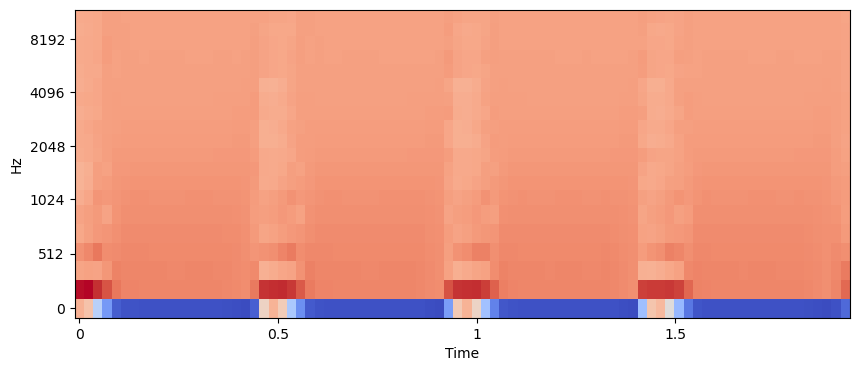

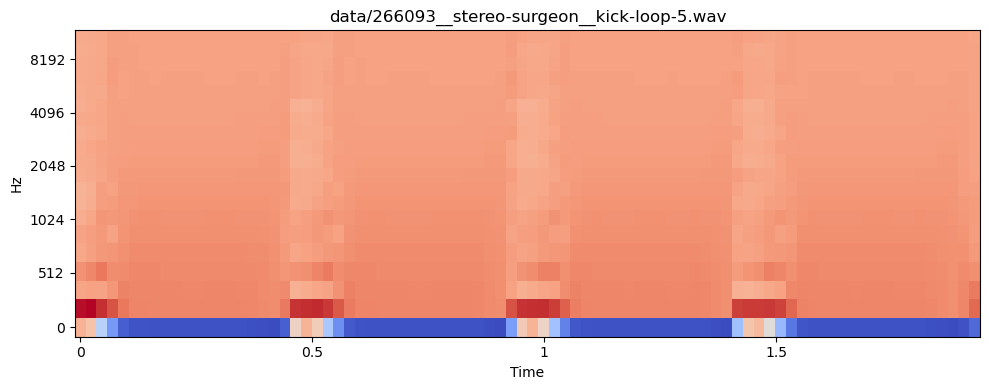

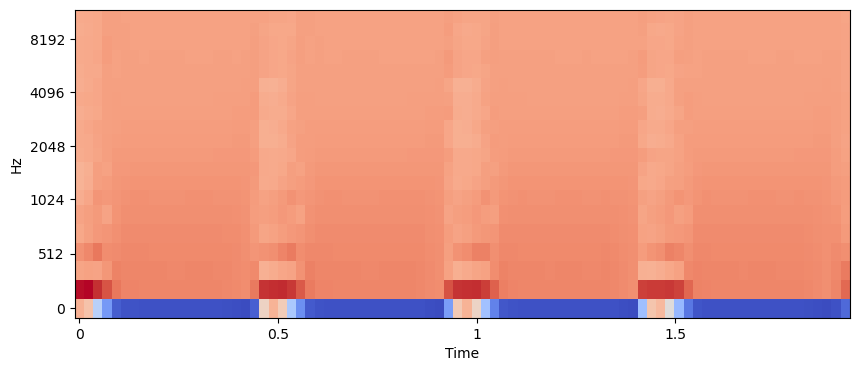

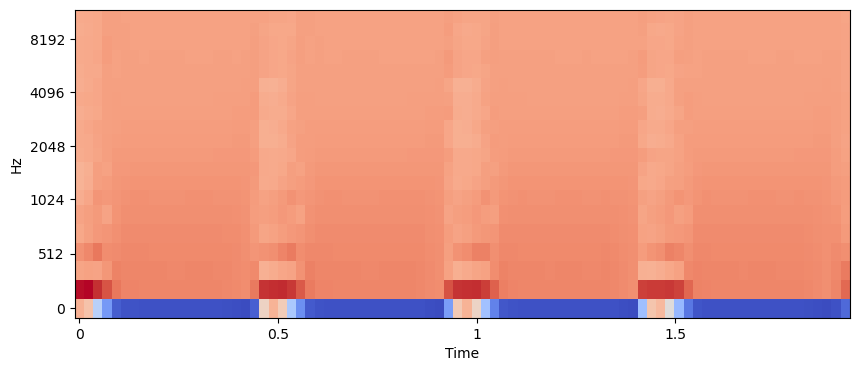

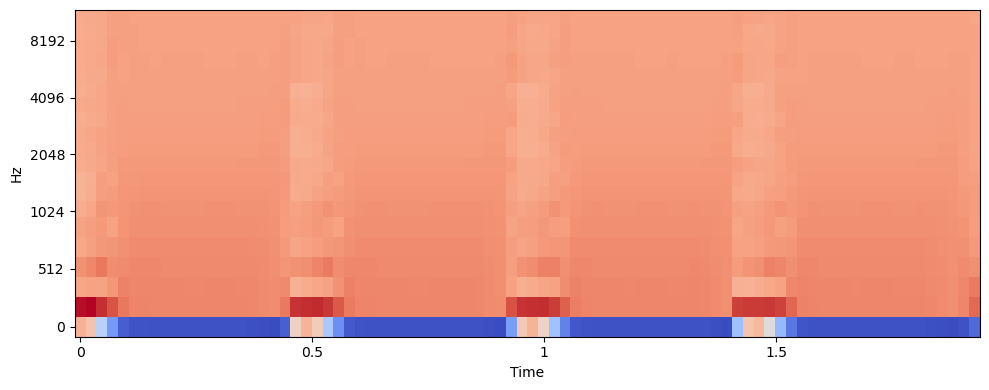

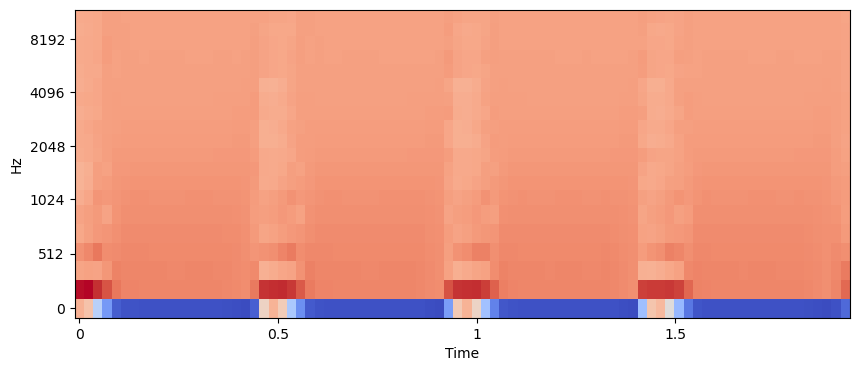

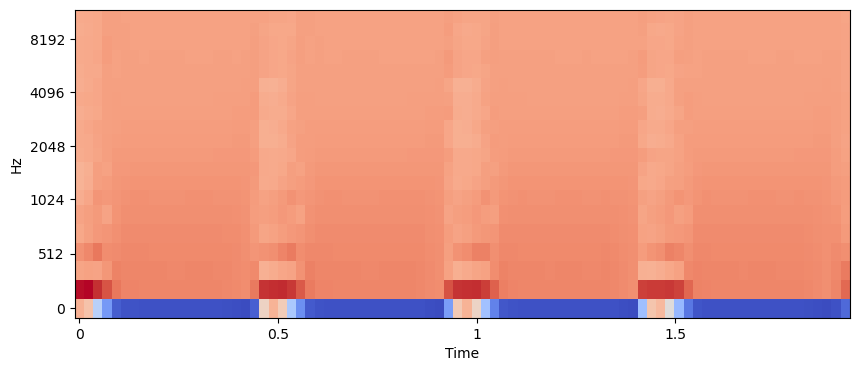

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [15]:
display_mfcc('data/266093__stereo-surgeon__kick-loop-5.wav')

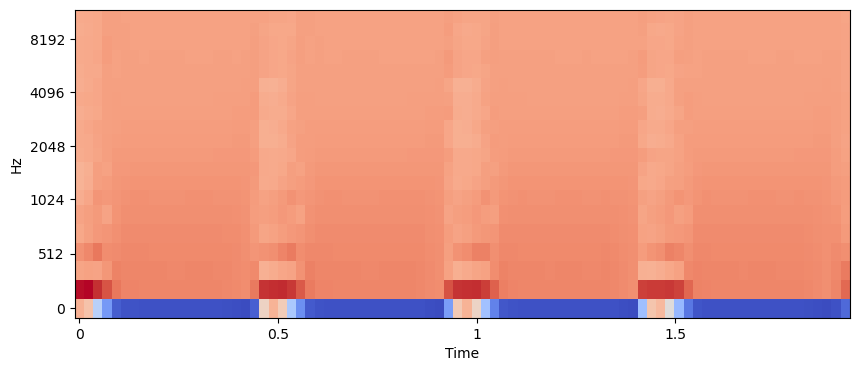

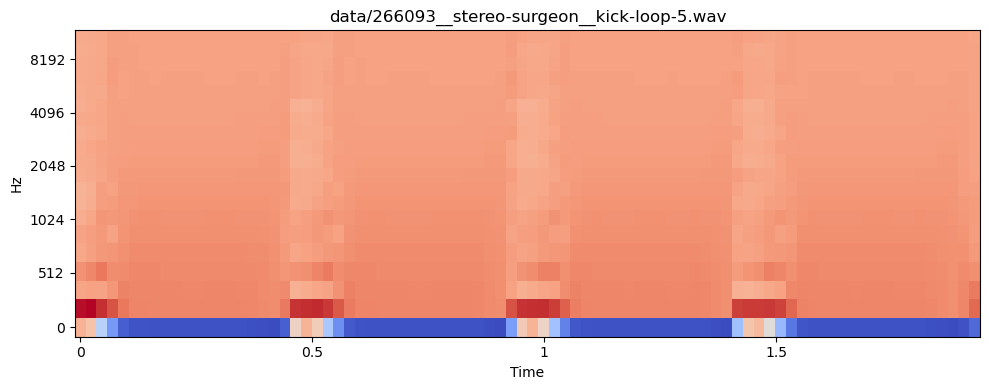

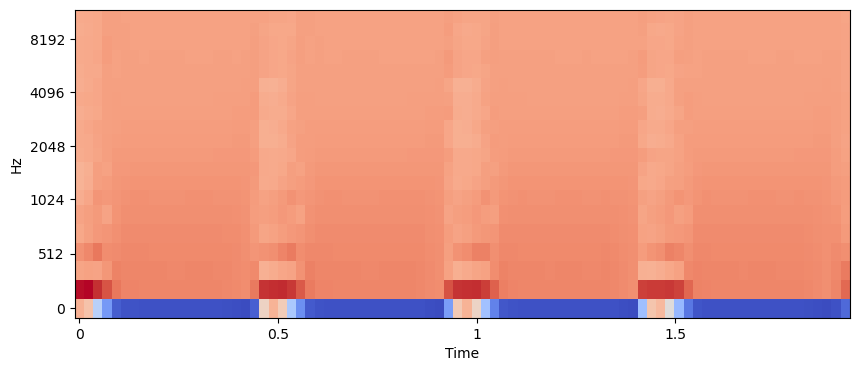

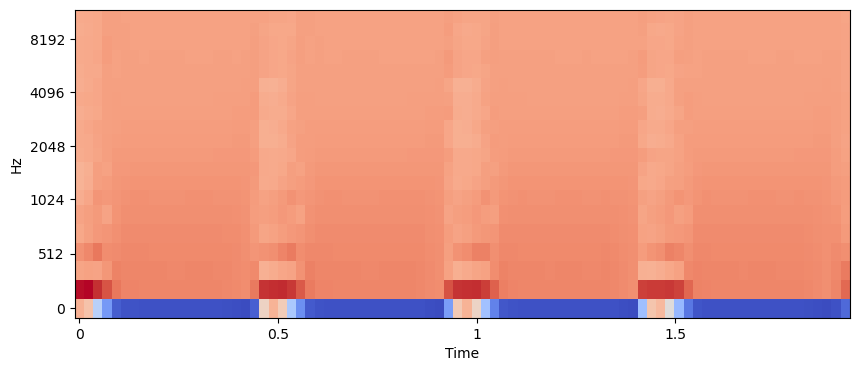

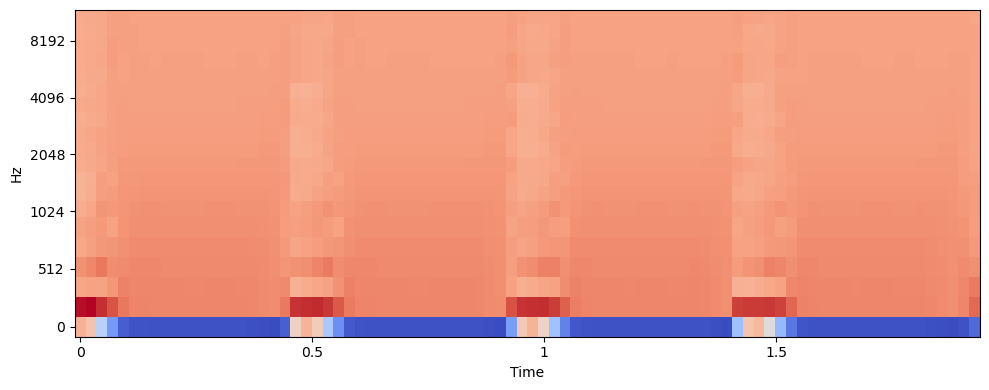

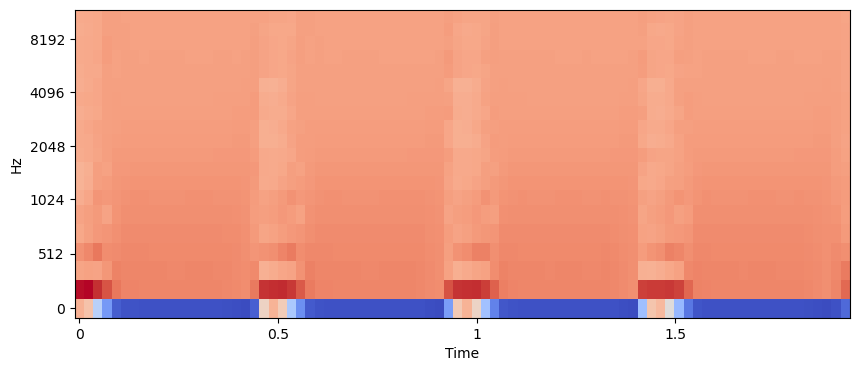

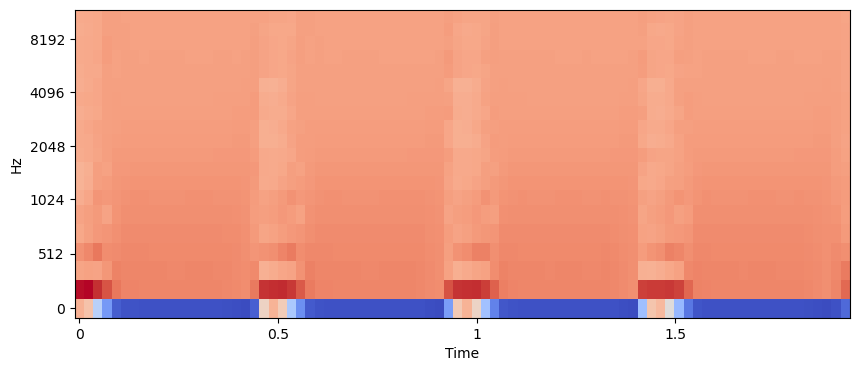

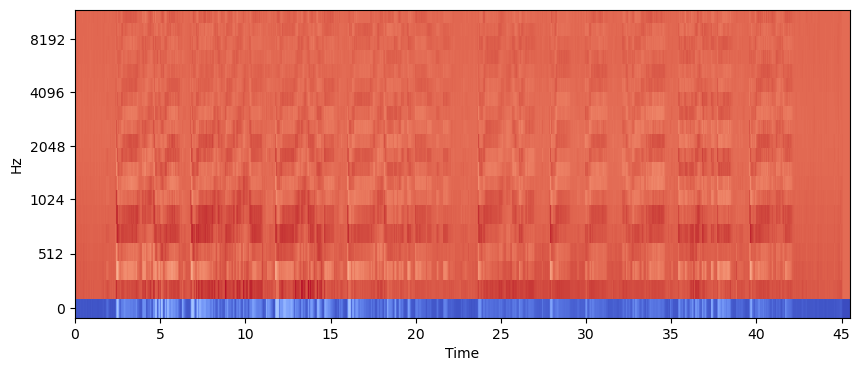

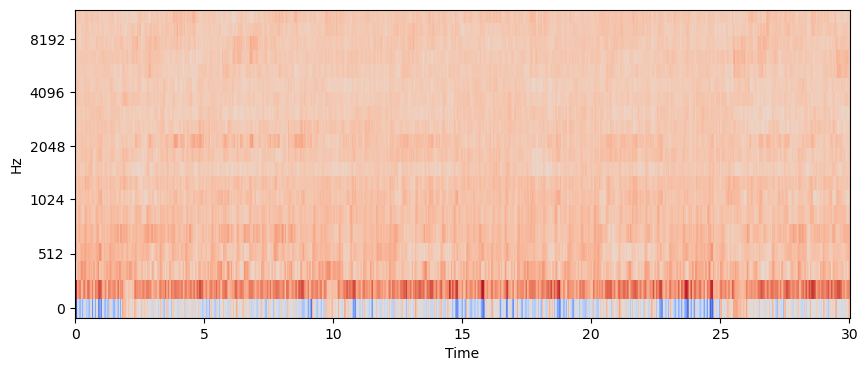

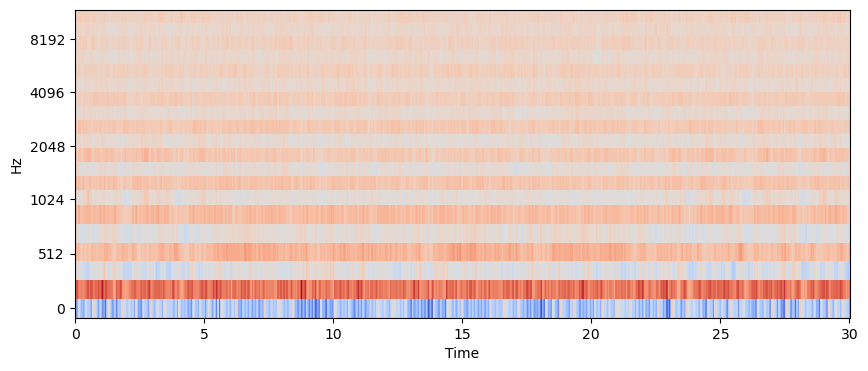

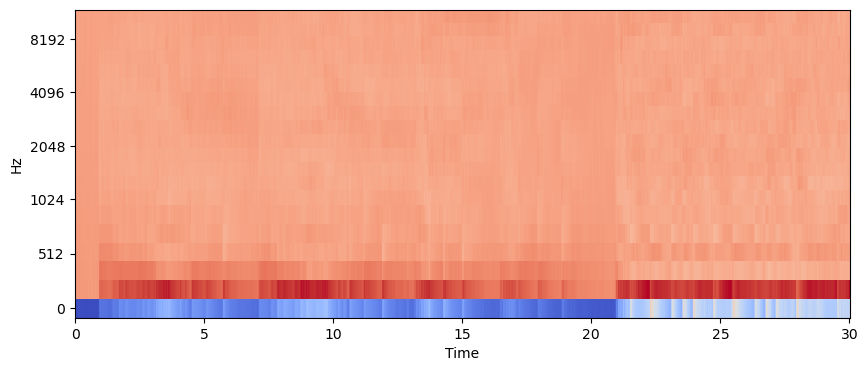

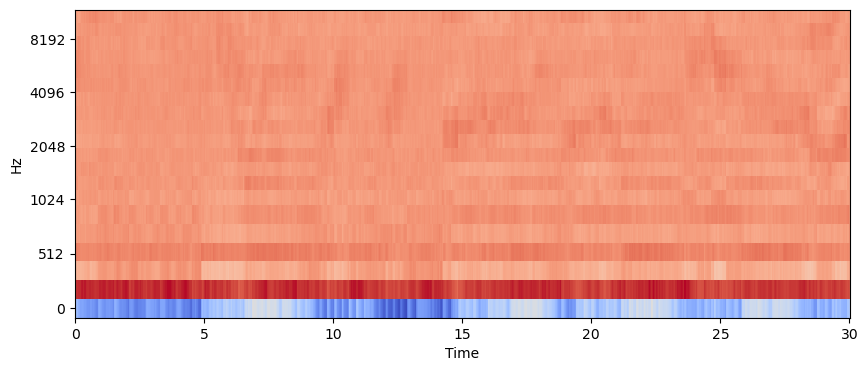

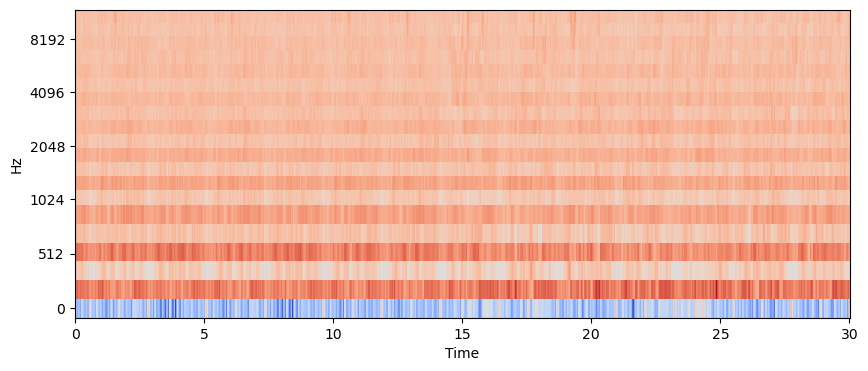

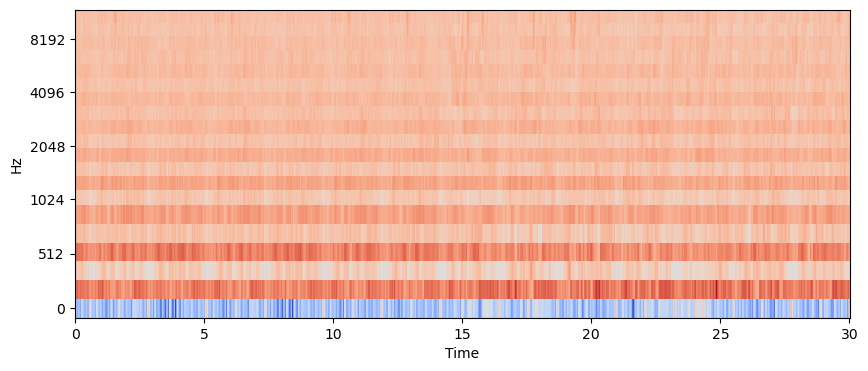

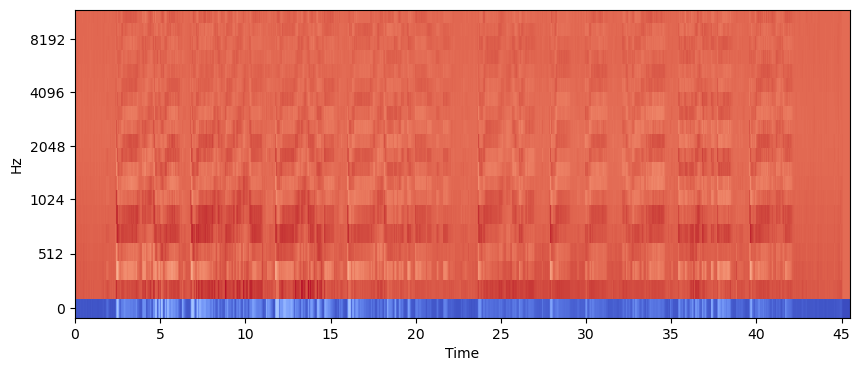

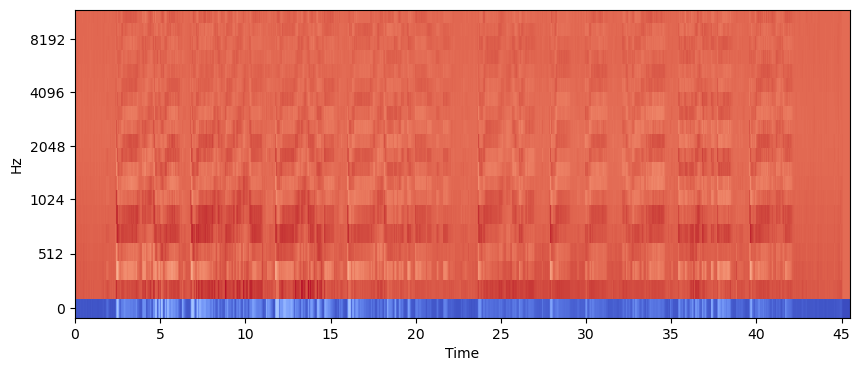

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [59]:
display_mfcc('data/98195__grrlrighter__whistling.wav')

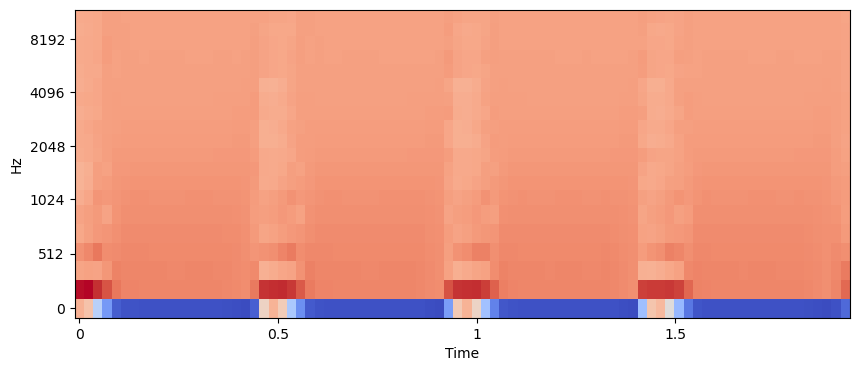

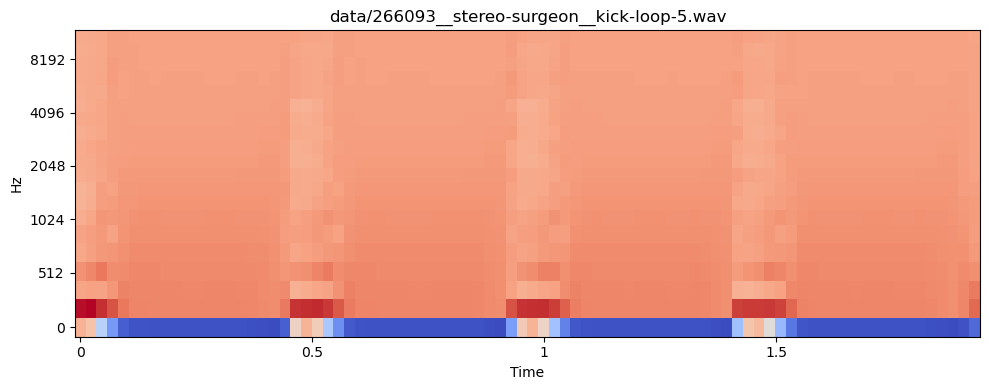

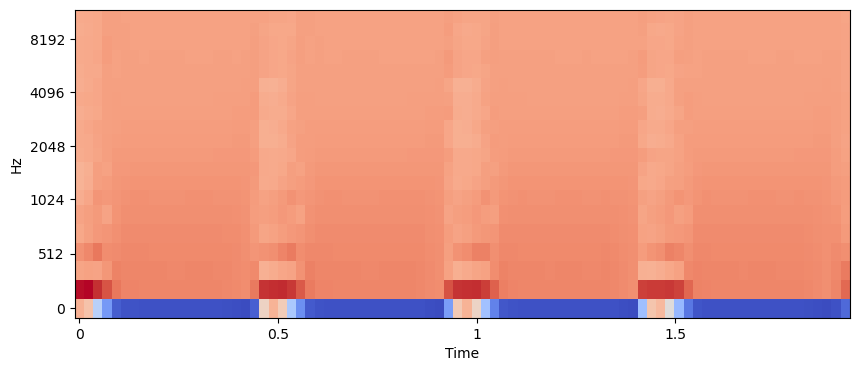

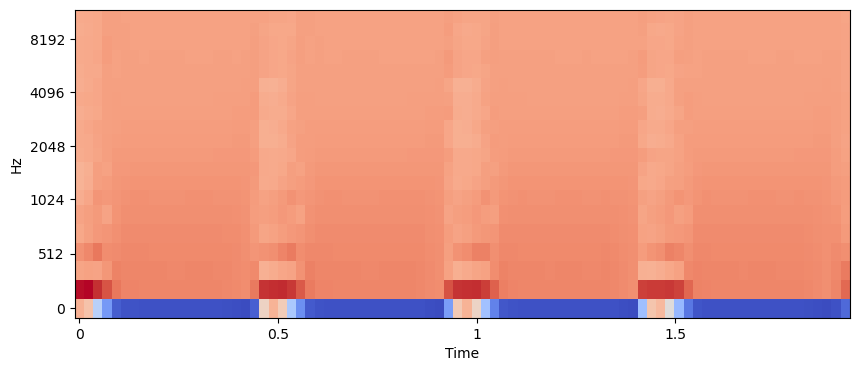

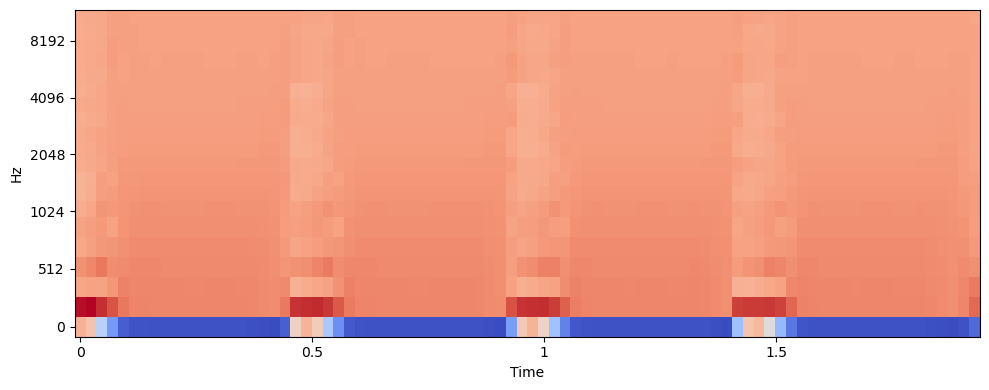

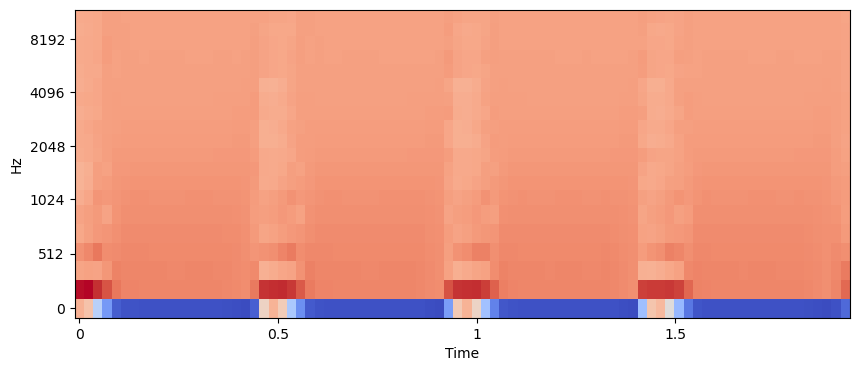

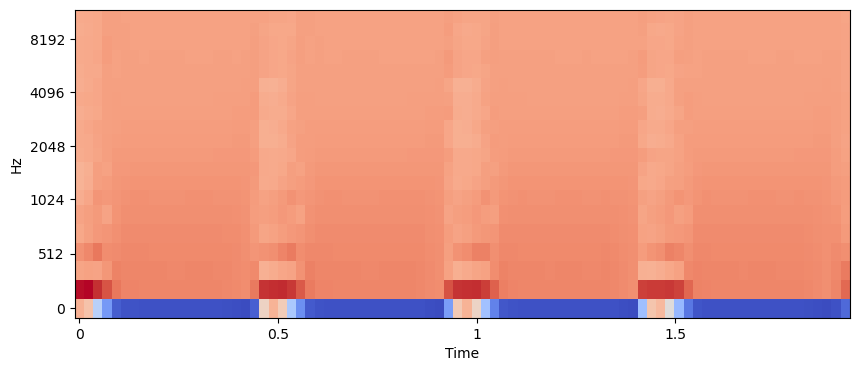

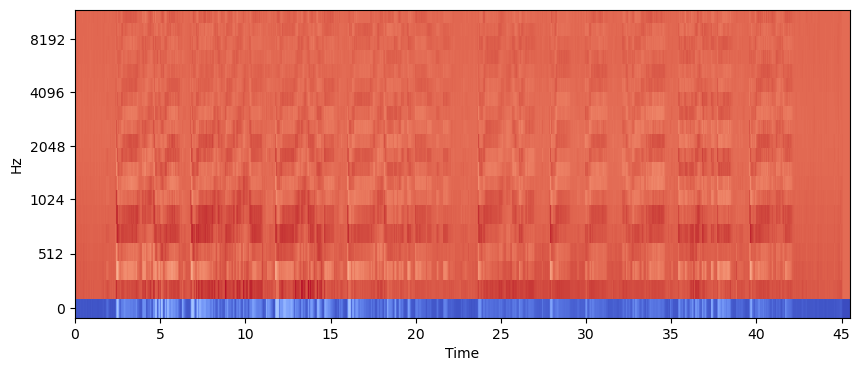

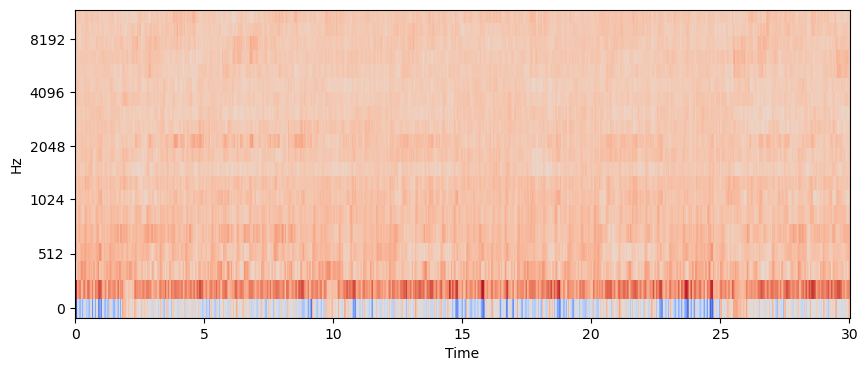

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [17]:
display_mfcc('data/genres_original/disco/disco.00035.wav')

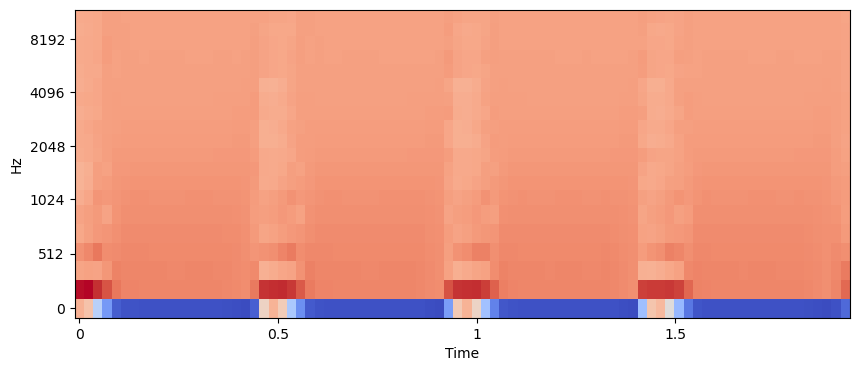

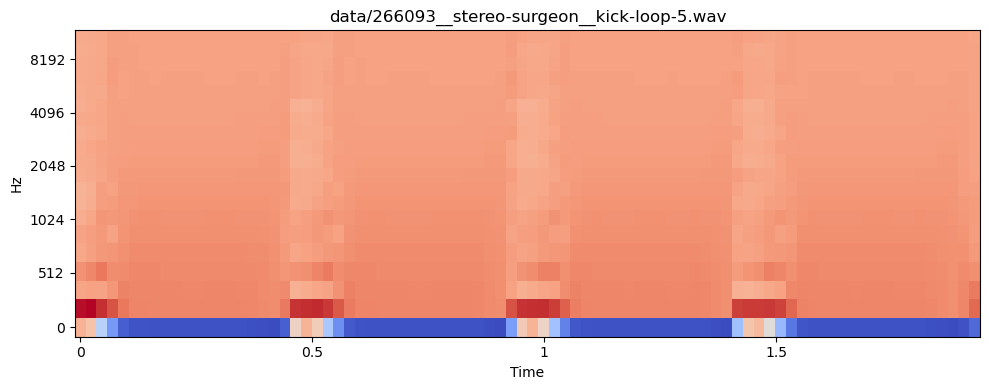

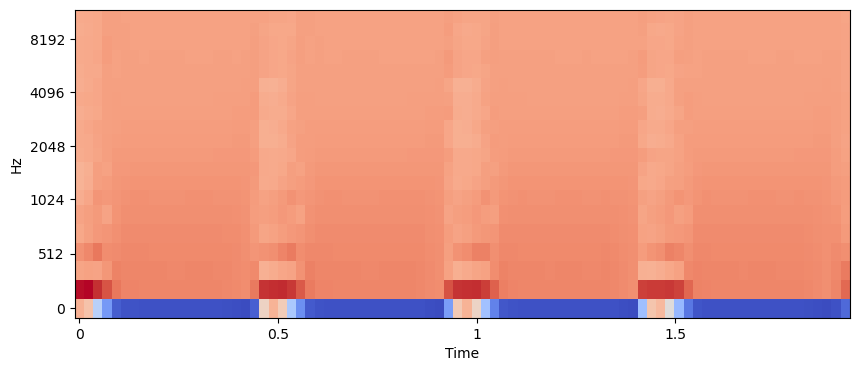

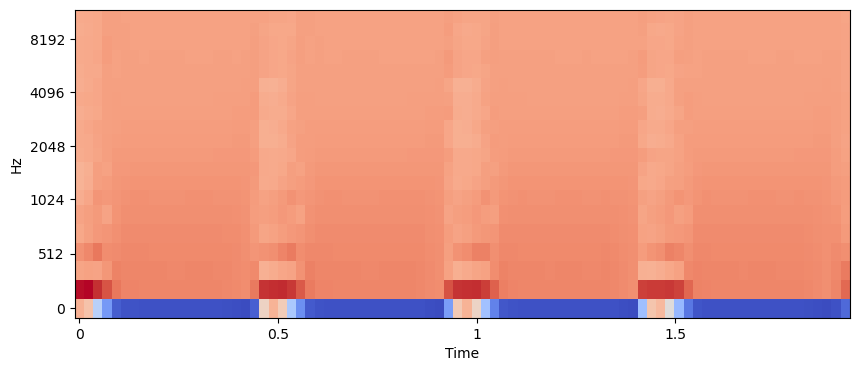

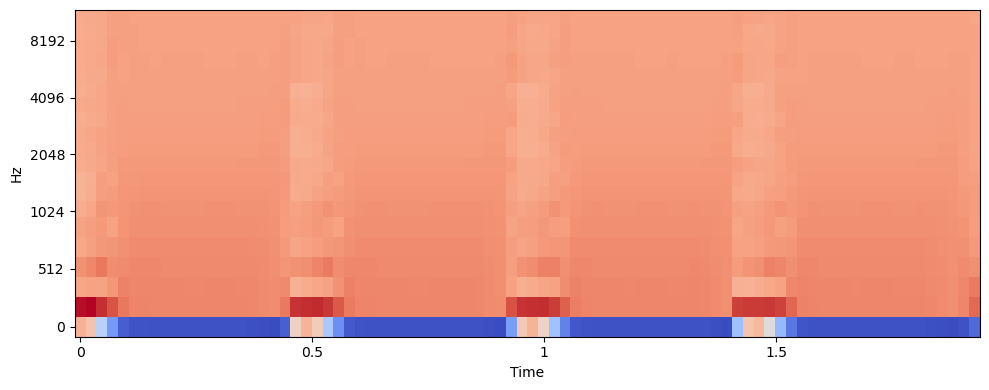

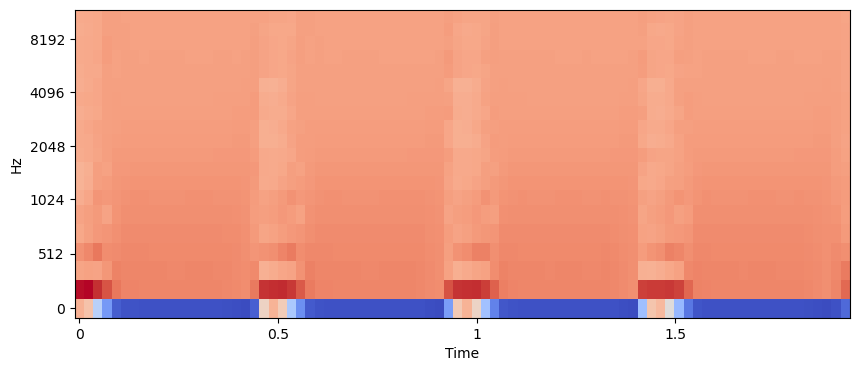

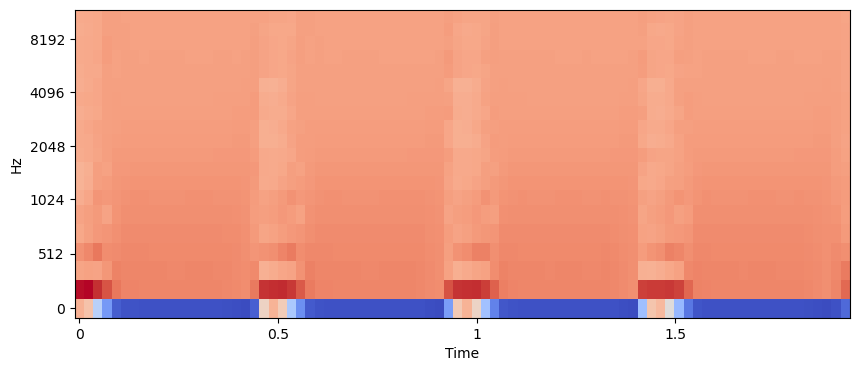

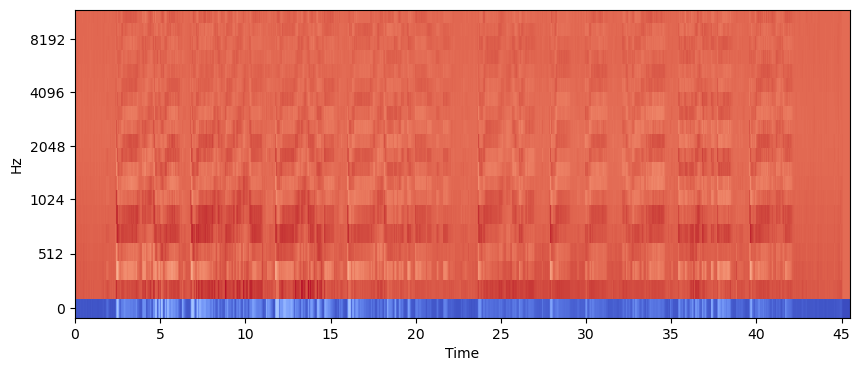

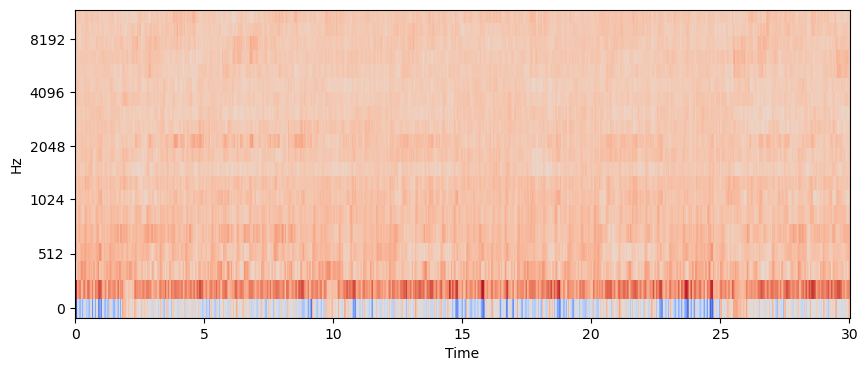

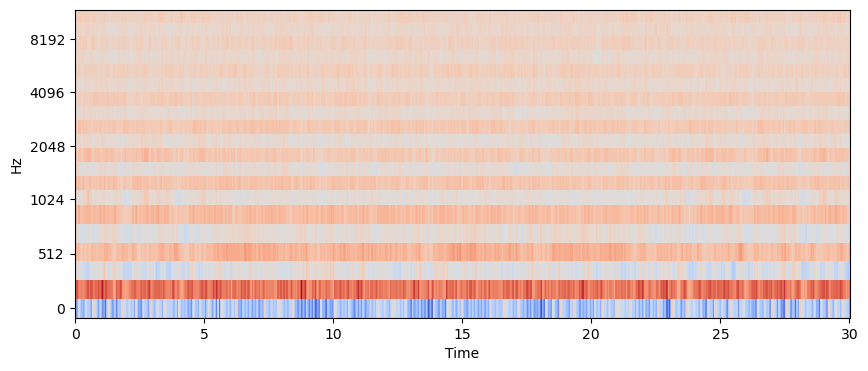

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [18]:
display_mfcc('data/genres_original/disco/disco.00070.wav')

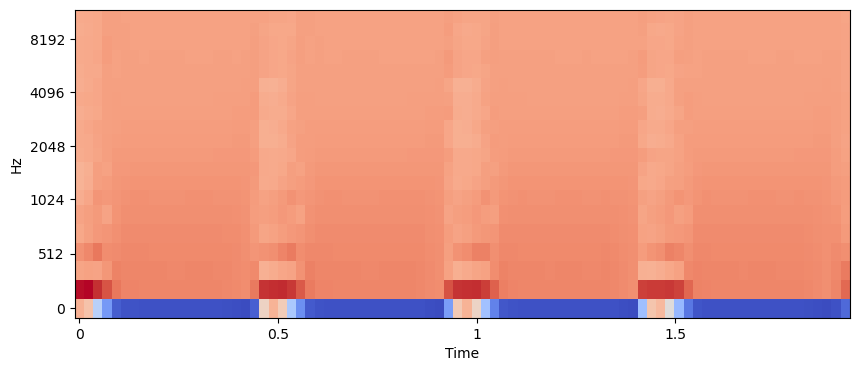

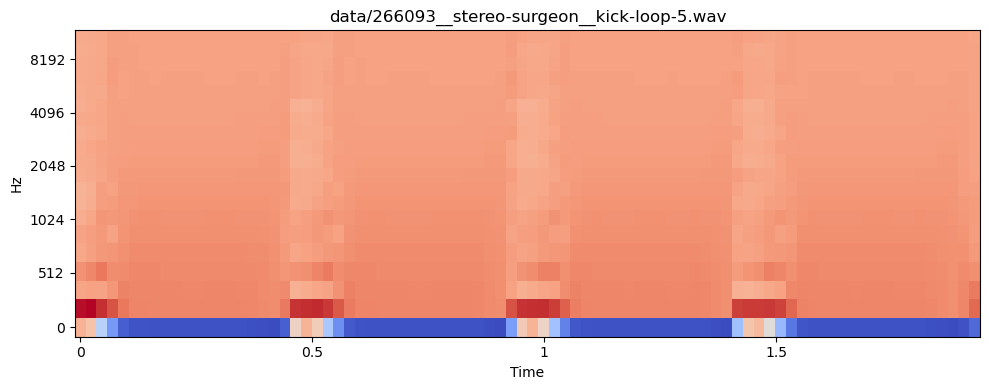

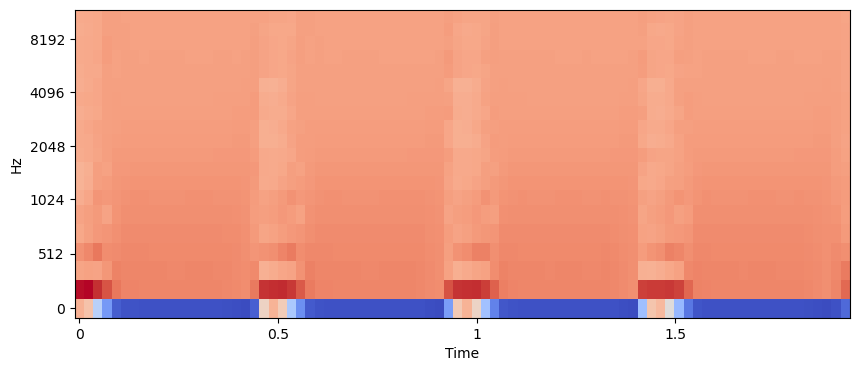

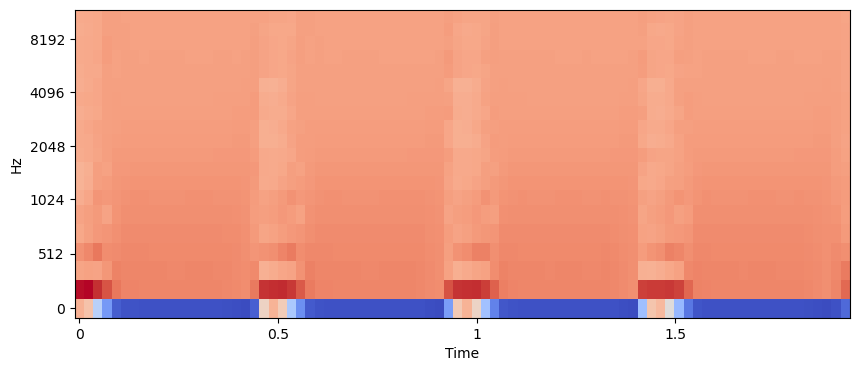

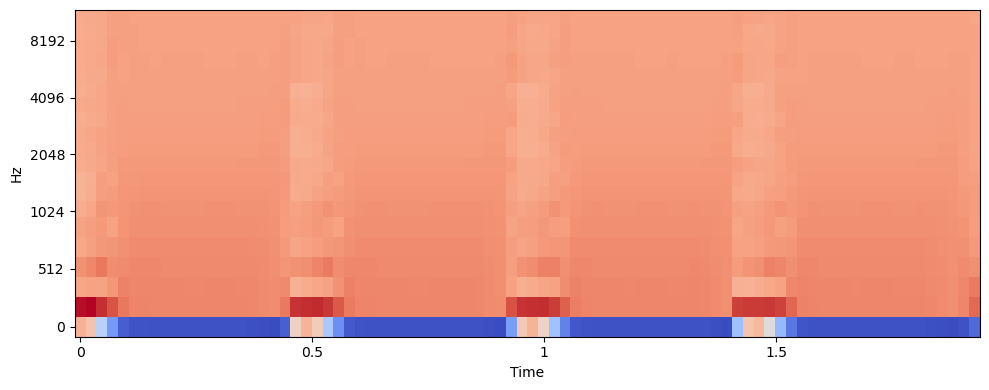

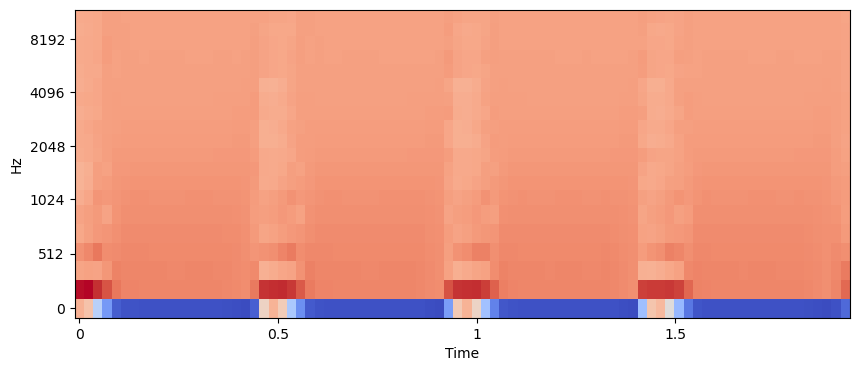

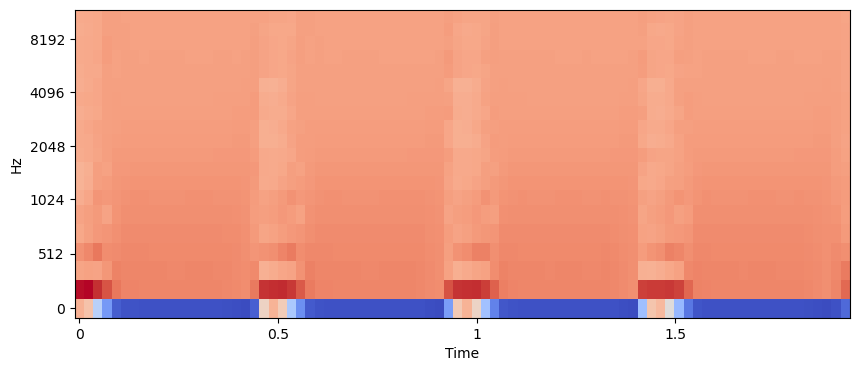

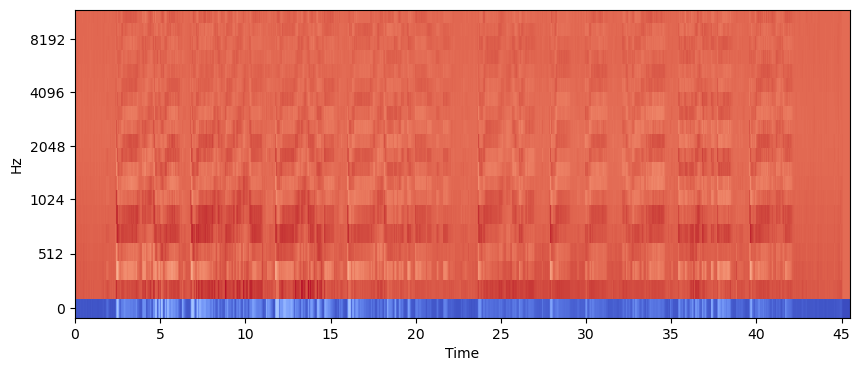

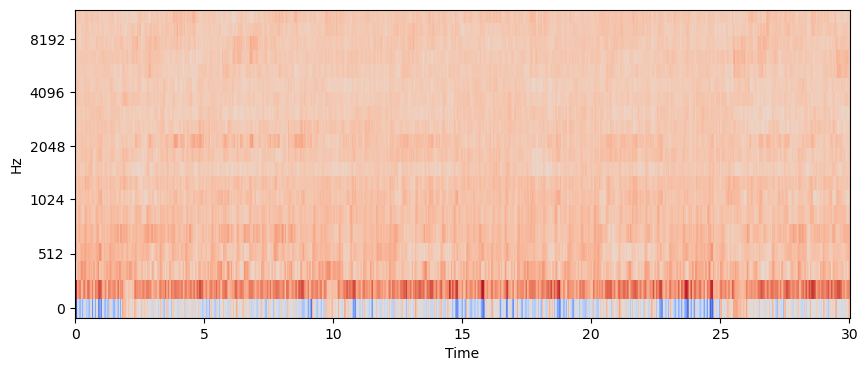

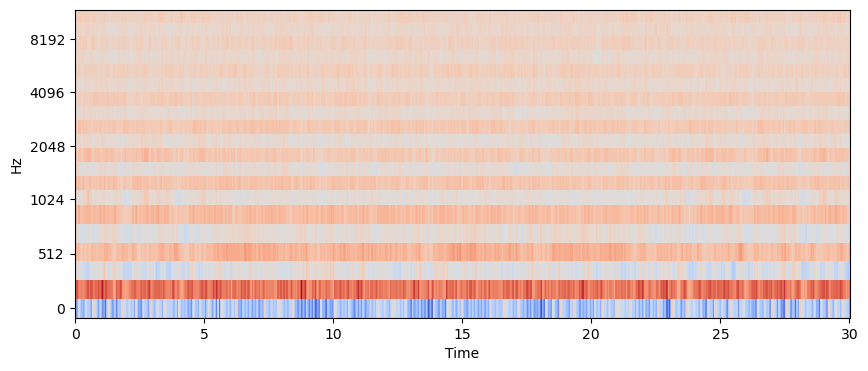

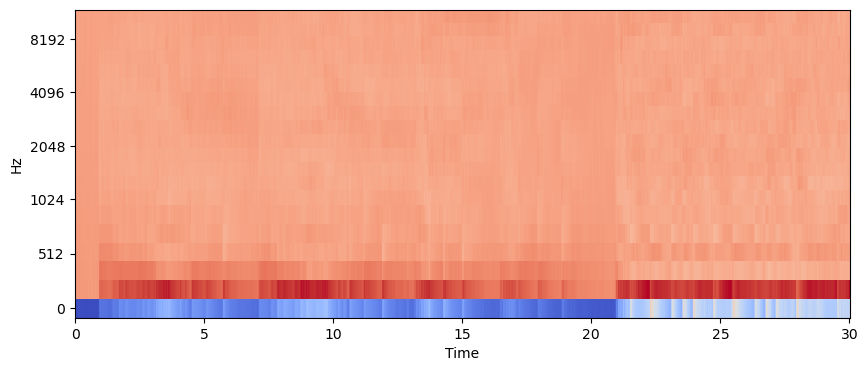

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [20]:
display_mfcc('data/genres_original/classical/classical.00067.wav')

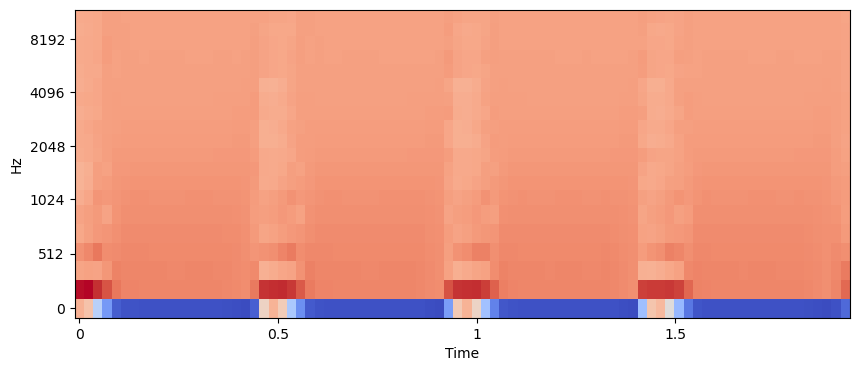

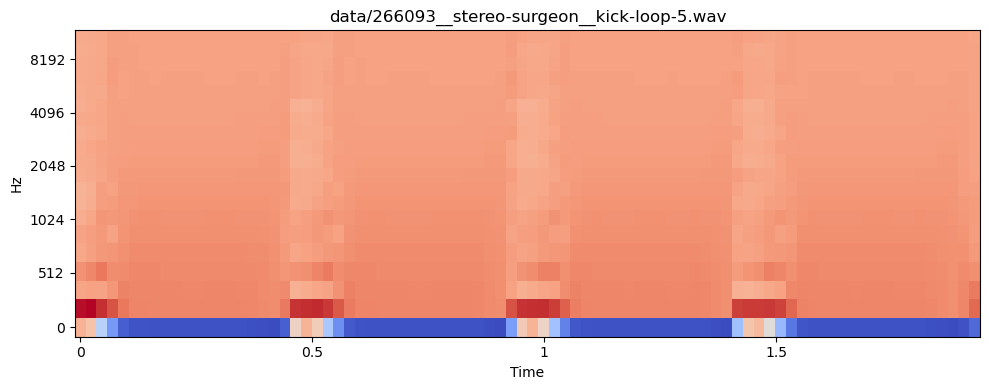

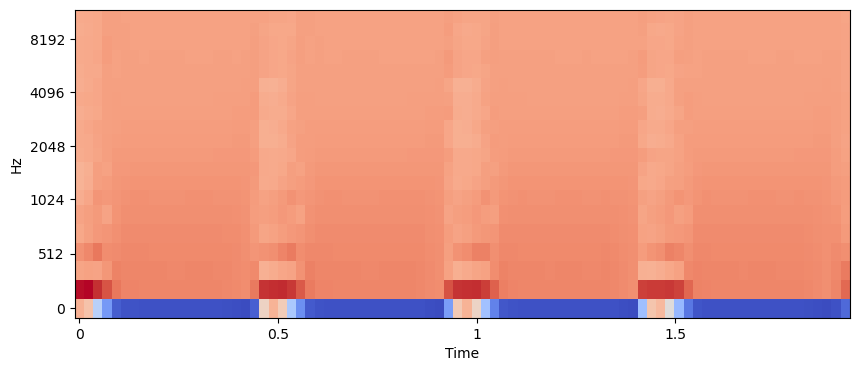

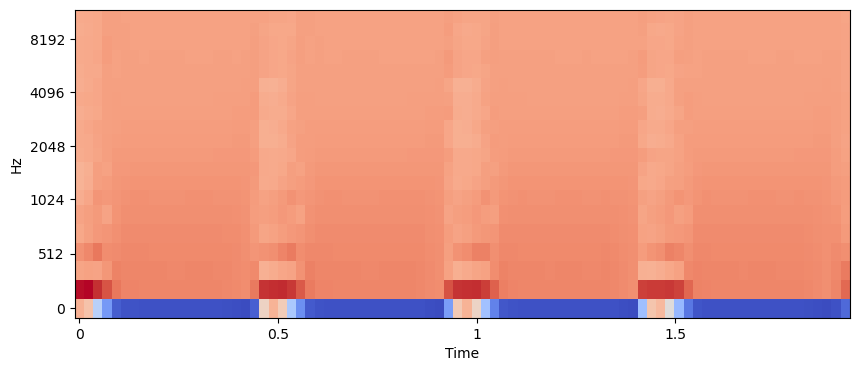

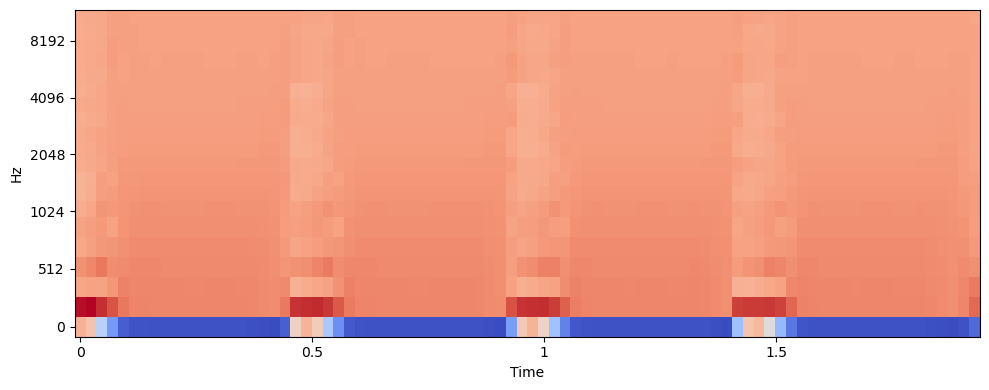

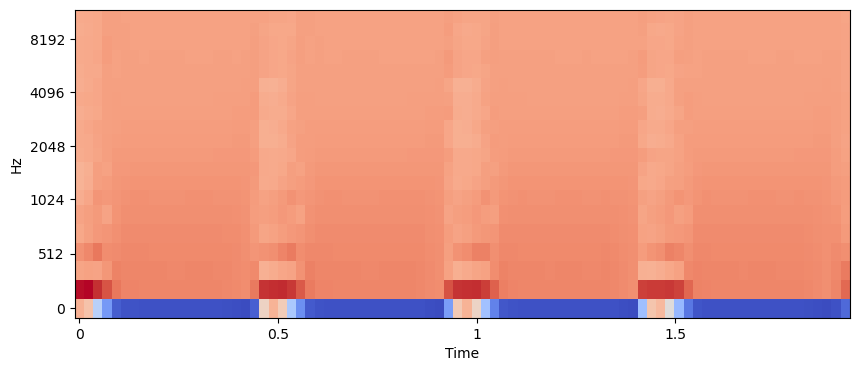

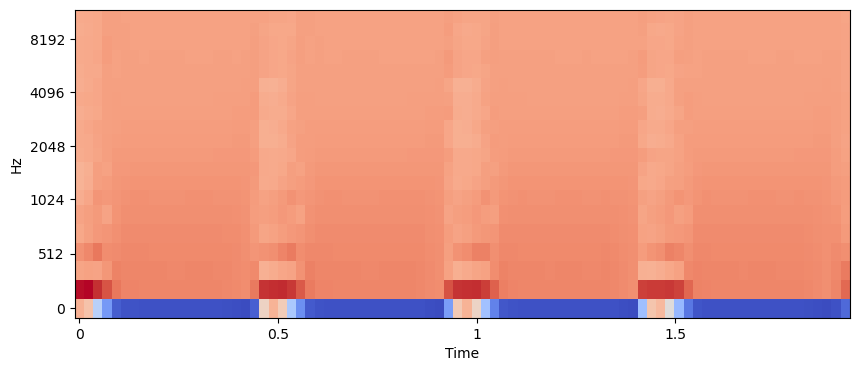

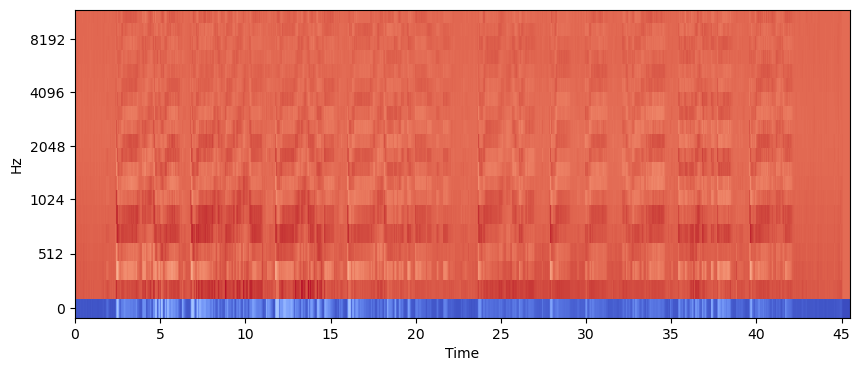

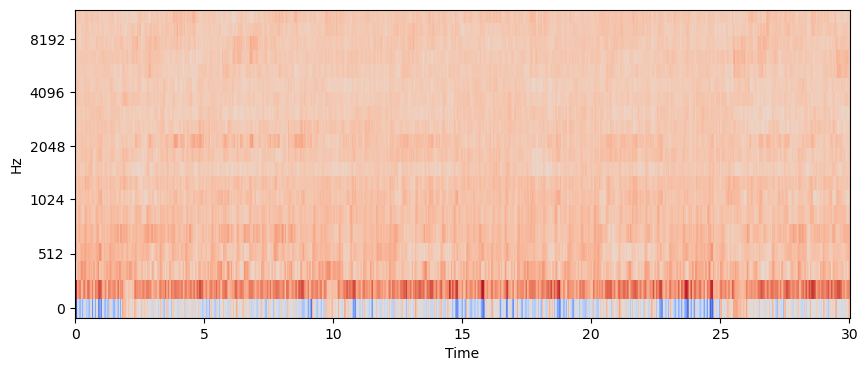

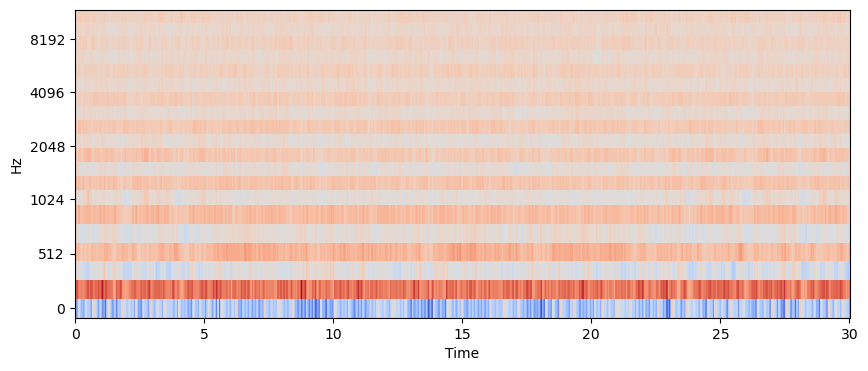

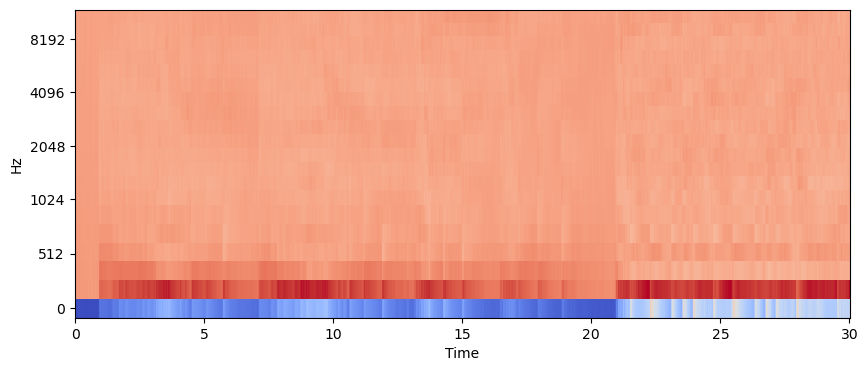

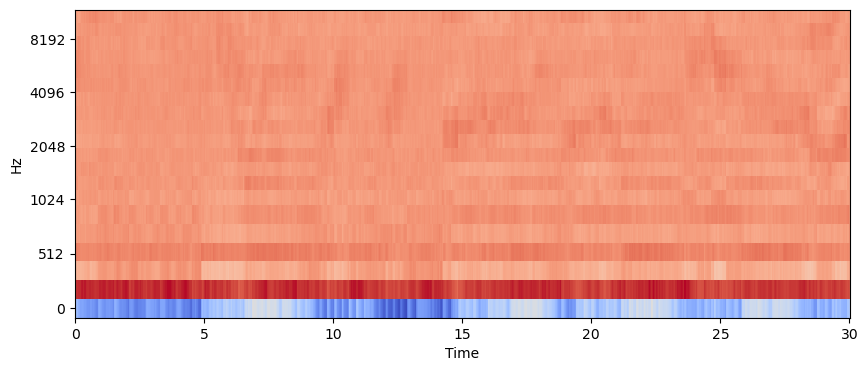

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [21]:
display_mfcc('data/genres_original/classical/classical.00010.wav')

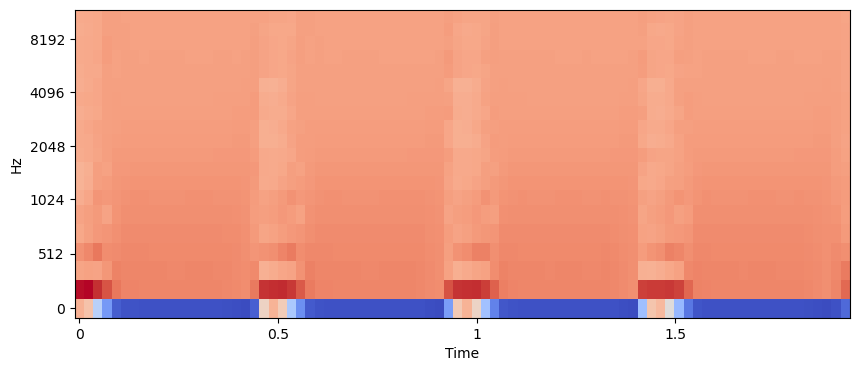

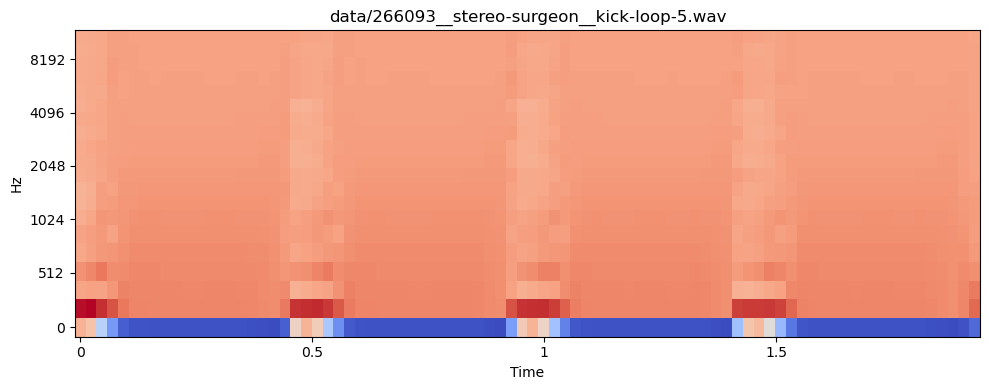

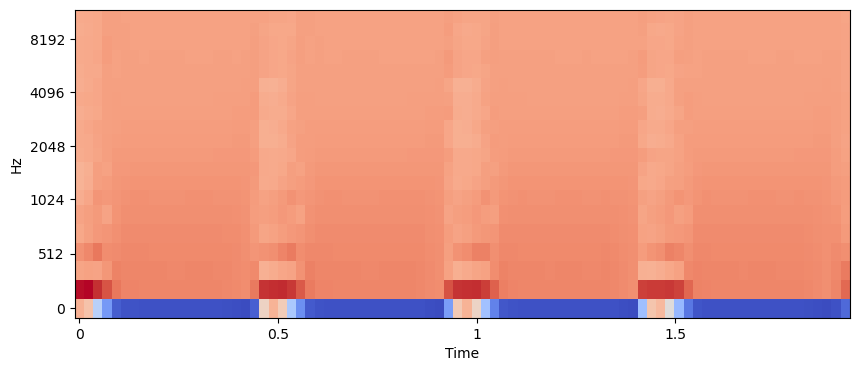

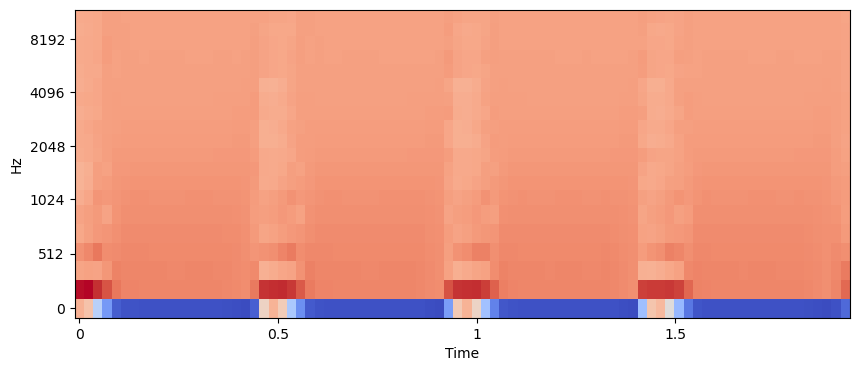

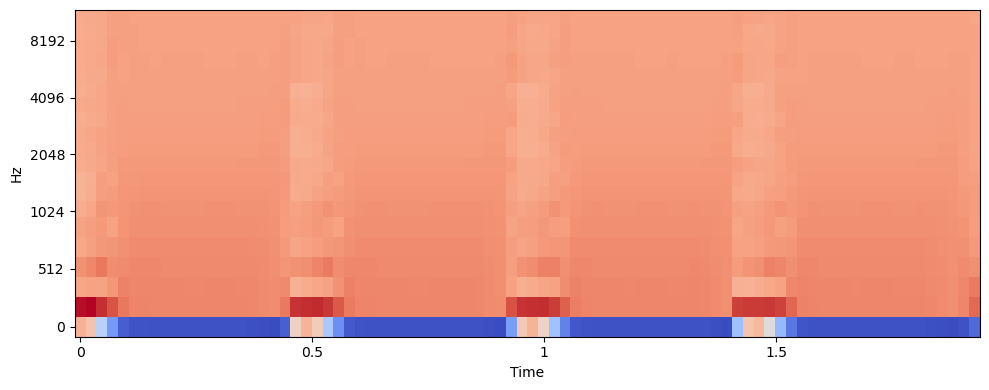

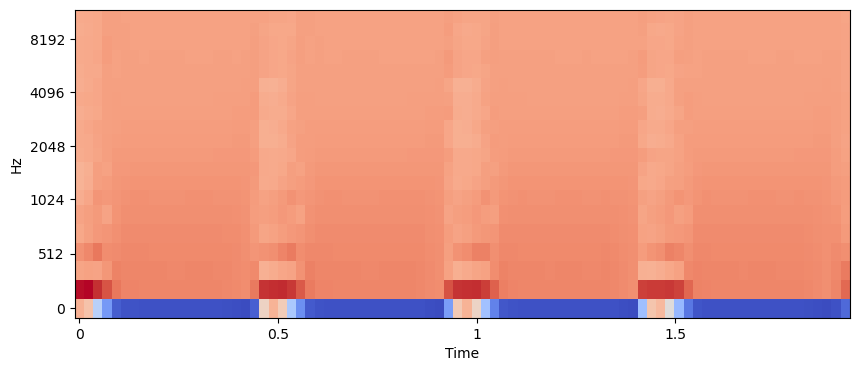

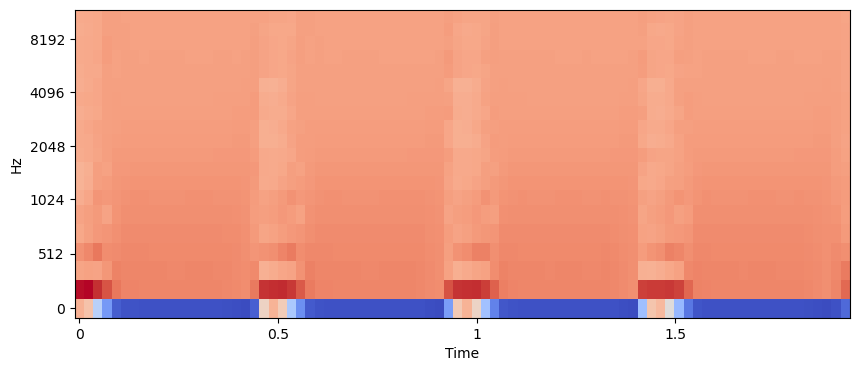

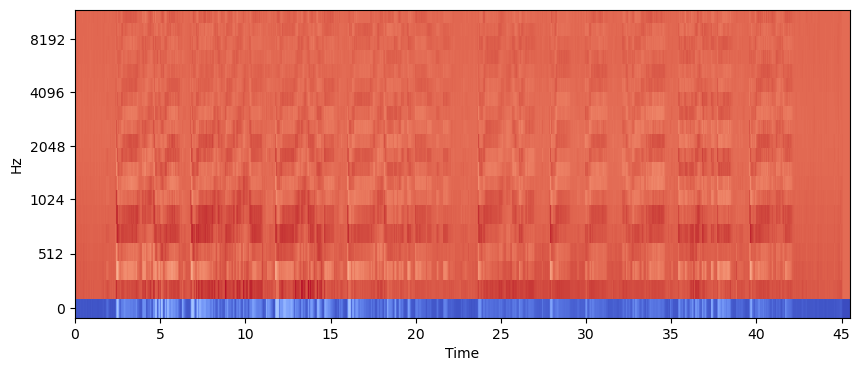

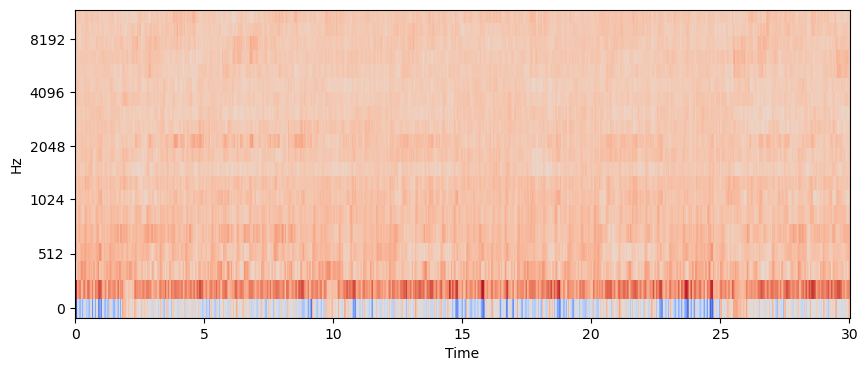

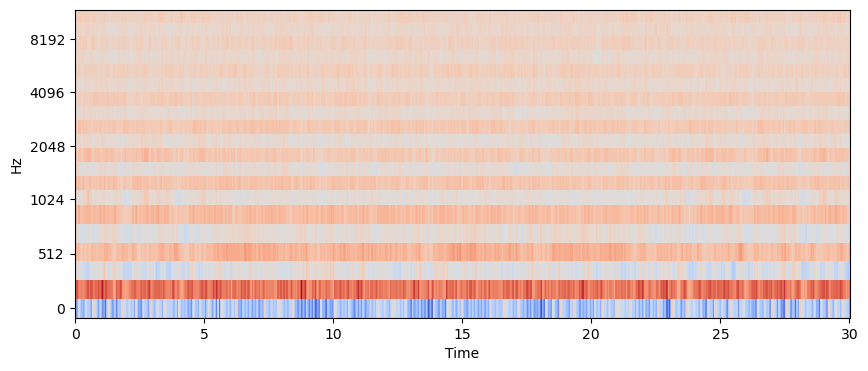

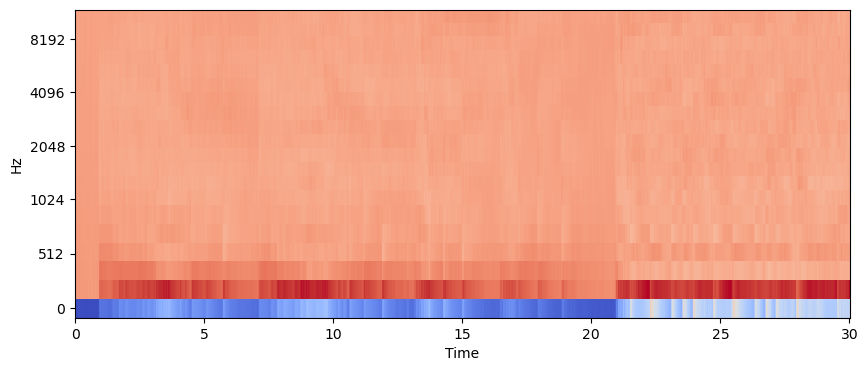

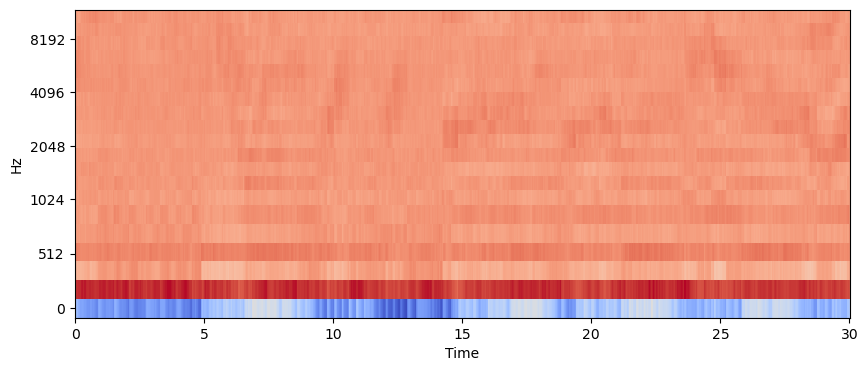

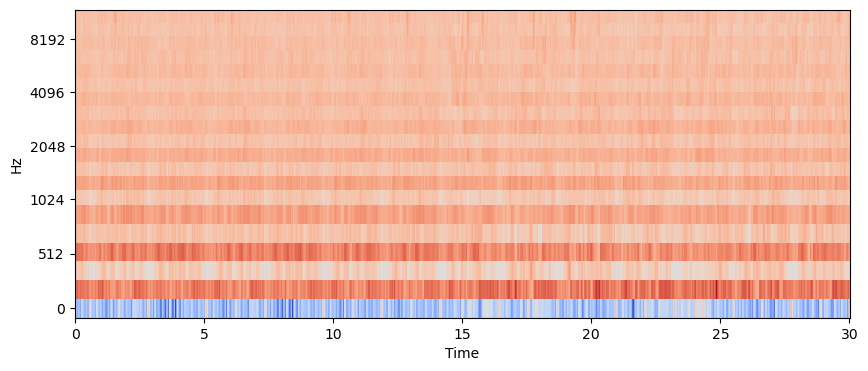

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [22]:
display_mfcc('/home/hugo/projects/sd_shipping_v2/Notebooks/data/genres_original/hiphop/hiphop.00098.wav')

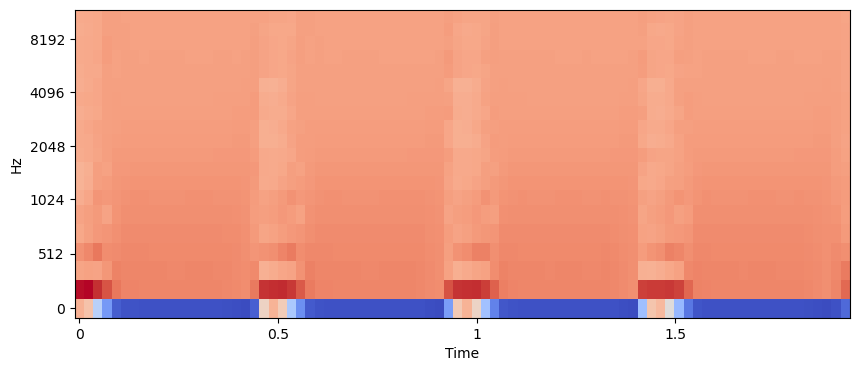

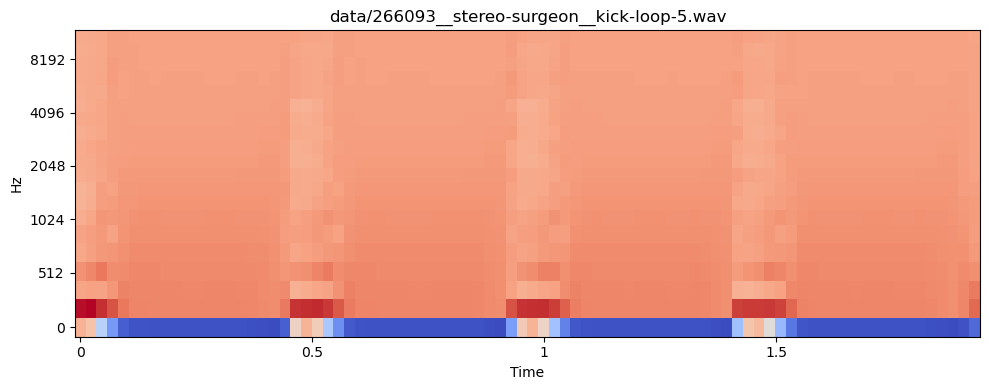

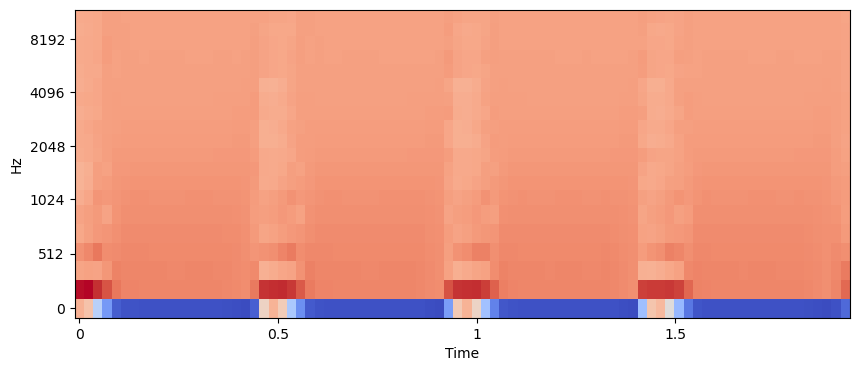

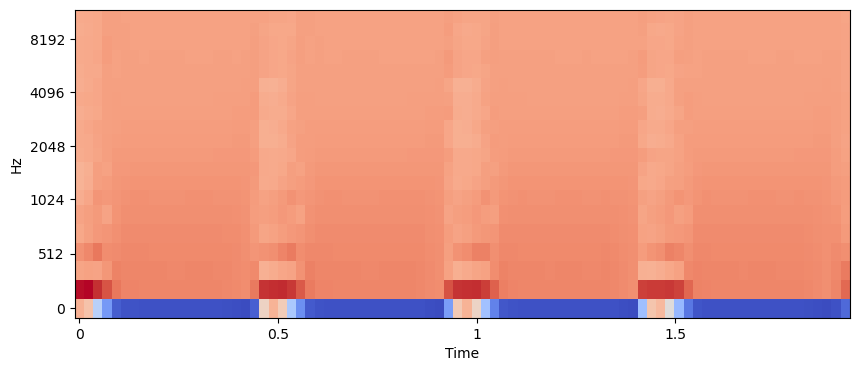

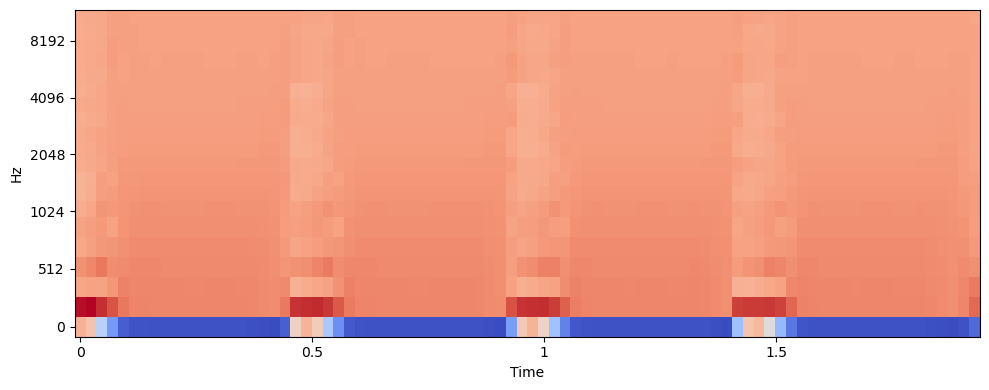

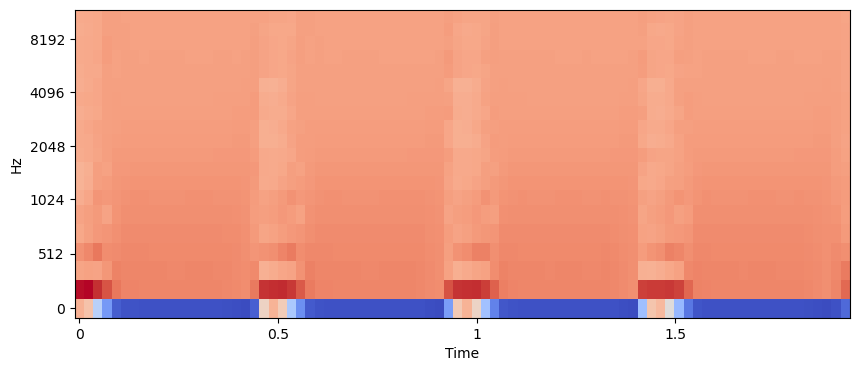

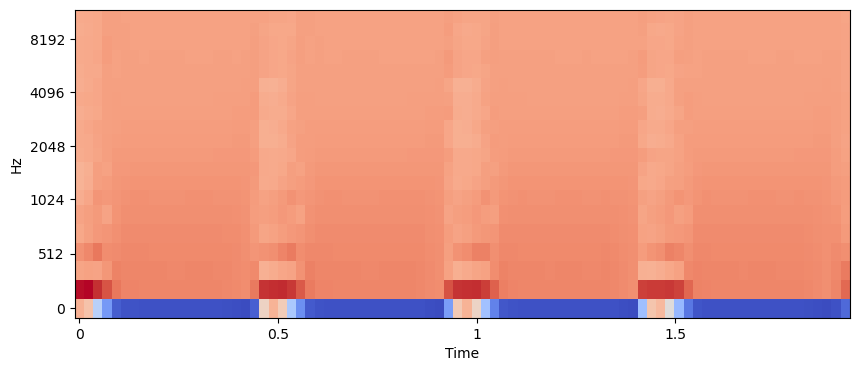

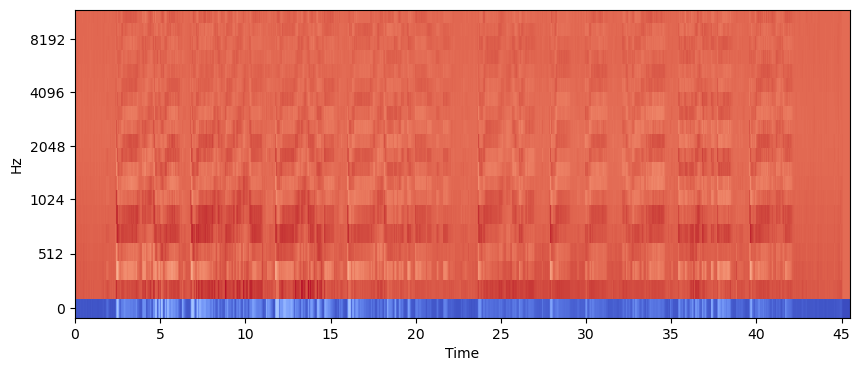

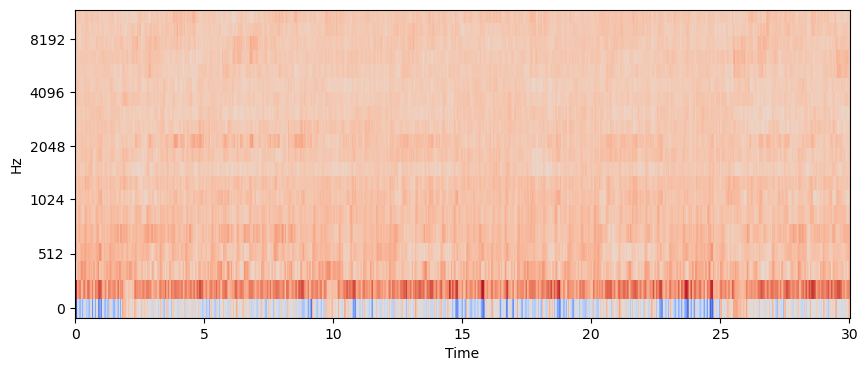

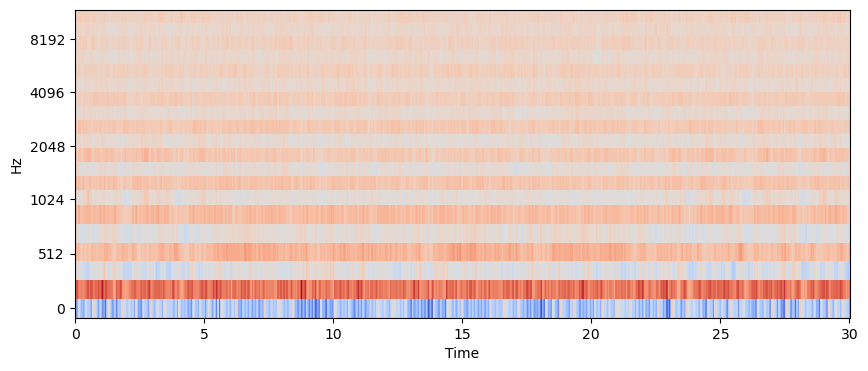

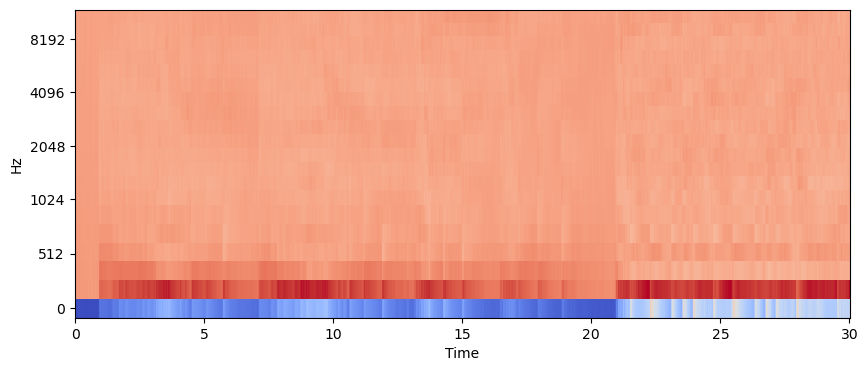

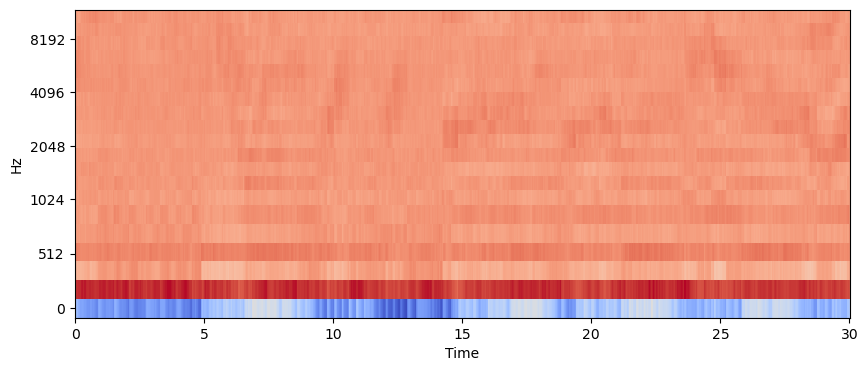

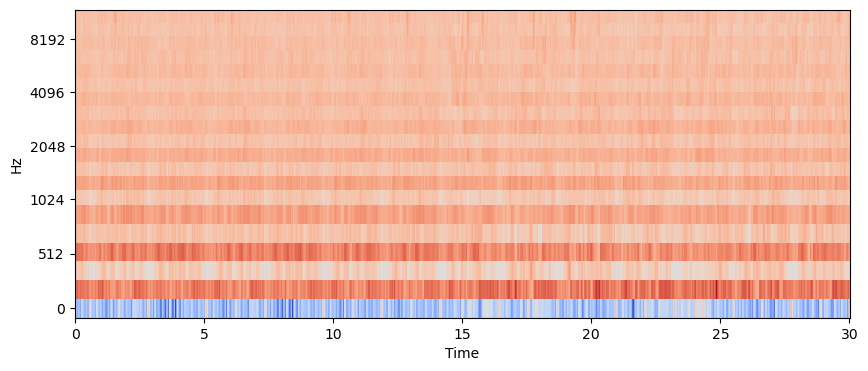

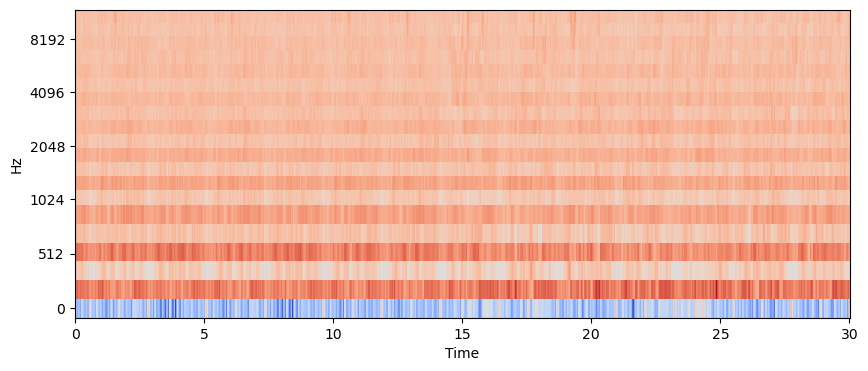

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [23]:
display_mfcc('data/genres_original/hiphop/hiphop.00098.wav')

In [48]:
def extract_features_song(f):
    y, _ = librosa.load(f)

    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y=y)
    # normalize values between -1,1 (divide by max)
    mfcc /= np.amax(np.absolute(mfcc))

    return np.ndarray.flatten(mfcc)[:25000]

In [54]:
import os
def generate_features_and_labels():
    all_features = []
    all_labels = []
#'blues', 'classical', 'country', 'disco', 'hiphop', 
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    for genre in genres:
        sound_files = os.listdir('data/genres_original/'+genre+'/')
        print('Processing %d songs in %s genre...' % (len(sound_files), genre))
        for f in sound_files:
            features = extract_features_song('data/genres_original/'+genre+'/'+f)
            all_features.append(features)
            all_labels.append(genre)

    # convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    return np.stack(all_features), onehot_labels

In [60]:
features, labels = generate_features_and_labels()

Processing 100 songs in blues genre...
Processing 100 songs in classical genre...
Processing 100 songs in country genre...
Processing 100 songs in disco genre...
Processing 100 songs in hiphop genre...
Processing 99 songs in jazz genre...
Processing 100 songs in metal genre...
Processing 100 songs in pop genre...
Processing 100 songs in reggae genre...
Processing 100 songs in rock genre...


In [56]:
print(np.shape(features))
print(np.shape(labels))

training_split = 0.8

# last column has genre, turn it into unique ids
alldata = np.column_stack((features, labels))

np.random.shuffle(alldata)
splitidx = int(len(alldata) * training_split)
train, test = alldata[:splitidx,:], alldata[splitidx:,:]

print(np.shape(train))
print(np.shape(test))

train_input = train[:,:-10]
train_labels = train[:,-10:]

test_input = test[:,:-10]
test_labels = test[:,-10:]

print(np.shape(train_input))
print(np.shape(train_labels))

(999, 25000)
(999, 10)
(799, 25010)
(200, 25010)
(799, 25000)
(799, 10)


In [57]:
model = Sequential([
    Dense(100, input_dim=np.shape(train_input)[1]),
    Activation('relu'),
    Dense(10),
    Activation('softmax'),
    ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

model.fit(train_input, train_labels, epochs=10, batch_size=32,
          validation_split=0.2)

loss, acc = model.evaluate(test_input, test_labels, batch_size=32)

print("Done!")
print("Loss: %.4f, accuracy: %.4f" % (loss, acc))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2500100   
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 2,501,110
Trainable params: 2,501,110
Non-trainable params: 0
_________________________________________________________________


2023-03-22 17:03:52.813370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 17:03:52.814787: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


None
Epoch 1/10
20/20 [==============================] - 4s 147ms/step - loss: 2.3364 - accuracy: 0.2676 - val_loss: 1.9201 - val_accuracy: 0.3625
Epoch 2/10
20/20 [==============================] - 2s 99ms/step - loss: 1.6989 - accuracy: 0.4225 - val_loss: 1.7198 - val_accuracy: 0.3938
Epoch 3/10
20/20 [==============================] - 2s 84ms/step - loss: 1.4361 - accuracy: 0.5008 - val_loss: 1.6376 - val_accuracy: 0.4000
Epoch 4/10
20/20 [==============================] - 2s 83ms/step - loss: 1.2347 - accuracy: 0.6103 - val_loss: 1.6212 - val_accuracy: 0.4125
Epoch 5/10
20/20 [==============================] - 2s 86ms/step - loss: 1.0124 - accuracy: 0.7089 - val_loss: 1.4537 - val_accuracy: 0.4938
Epoch 6/10
20/20 [==============================] - 2s 80ms/step - loss: 0.8694 - accuracy: 0.7840 - val_loss: 1.4499 - val_accuracy: 0.5188
Epoch 7/10
20/20 [==============================] - 2s 79ms/step - loss: 0.7413 - accuracy: 0.8185 - val_loss: 1.4406 - val_accuracy: 0.5063
Epoch 8